# Aprendizagem de Máquina I

## Hugo Tremonte de Carvalho

#### hugo@dme.ufrj.br

* NOME: João Victor Barboza Machado das Neves
* DRE: 117081393
* E-MAIL CADASTRADO NO CLASSROOM: j.victor.neves7@gmail.com

Este _notebook_ é correspondente ao nosso primeiro projeto, passado no dia 18/09/2025 e para entrega no dia 05/10/2024. Ele consiste em resolver um problema prático. A entrega da atividade deve ser feita através do Google Classroom, fazendo um _upload_ deste _notebook_, devidamente atualizado com as suas resoluções e implementações. Recomendo fortemente que façam o trabalho no Google Colab, pois assim temos certa garantia de estarmos rodando tudo no mesmo ambiente e que eu conseguir executar o código de vocês sem dificuldades.

O projeto é **individual**.

O objetivo do projeto é analisar uma base de dados contendo informações sobre corridas de Uber, e tentar prever o valor da corrida com base em atributos de interesse. A base de dados encontra-se disponível [aqui](https://www.kaggle.com/datasets/yasserh/uber-fares-dataset).

O arquivo `.csv` tem poucas colunas: `fare_amount` é a coluna que desejamos prever, e temos também as colunas abaixo para usar como preditoras:
* `key` - _a unique identifier for each trip_
* `pickup_datetime` - _date and time when the meter was engaged_
* `passenger_count` - _the number of passengers in the vehicle (driver entered value)_
* `pickup_longitude` - _the longitude where the meter was engaged_
* `pickup_latitude` - _the latitude where the meter was engaged_
* `dropoff_longitude` - _the longitude where the meter was disengaged_
* `dropoff_latitude` - _the latitude where the meter was disengaged_

Note que a coluna `key` não será um preditor, já que contém somente uma variável de identificação da corrida. Porém, para que as outras colunas sejam propriamente utilizadas como preditoras, talvez seja necessário algum pré-processamento:
* Precisaremos converter as informações de latitude e longitude em distância ou nossos algoritmos serão capazes de fazê-lo "automaticamente"? Mesmo caso o façam, ter a distância logo de cara auxilia no processo de previsão?
* A coluna `pickup_datetime` tem muita informação útil, e pode ser convertida em muitas outras informações para te auxiliar na predição, por exemplo: dia da semana da corrida, se é feriado ou não, etc... porém, essas informações não são imediatas e vão requerer um certo "trabalho sujo" da sua parte, bem como um tico de ferramentas de processamento de texto :-)
* Note que, ao converter `pickup_datetime` para, digamos, dia da semana, será necessário converter essa informação em algo numérico. Aplicar `One Hot Encoding` é uma boa opção? Estude isso com carinho.
* Note que algumas variáveis podem ter alguns valores esquisitos: procure cuidadosamente por dados faltantes e/ou valores irreais (p. ex., corridas com 10 passageiros ou começando no Pólo Norte)

Alguns pontos que o seu trabalho deve conter:
* Análise exploratória bem aprofundada e interpretada: os nossos dados são muito interpretáveis! Além de fazer o que já esperamos (estudar correlações, visualizar histogramas, etc.), sua análise exploratória deve ser esclarecedora sobre distância entre ponto de partida e ponto de chegada, distribuição das corridas ao longo dos dias da semana, distribuição das corridas ao longo dos meses, estudar como (potencialmente) os atributos se relacionam com a resposta (sem e com pré-processamento), analisar (possível) influência do número de passageiros no preço da corrida, etc... Portanto, não basta fazer meia dúzia de gráficos para "cumprir tabela"! A análise exploratória deve informar muito sobre a base de dados e guiar os próximos passos!
* Descrição da criação de novos atributos a partir das colunas já presentes na base, caso você o faça
* Treinamento e validação de todos os modelos de regressão que vimos até o momento, juntamente com uma interpretação de seus resultados
* Em particular, os coeficientes das regressões paramétricas devem ser interpretados, bem como a `feature_importance_` dos modelos baseados em árvores
* Decisão de um "melhor" modelo para realizar previsões, com justificativa

Tome cuidado que a base é grande: poucos atributos porém muitas linhas! É bem provável que você precise tomar cuidado ao usar métodos pesados como `GridSearchCV`, ou até mesmo nos métodos `.fit()` dos nossos estimadores. Usar as coisas ingenuamente pode ser computacionalmente inviável. Seja sagaz em suas escolhas!

Parte 1) Pré-Processamento dos dados, Criação de Novos atributos e Análise Exploratória

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

1.1) Pré-processamento dos dados

In [2]:
#Carregando a base de dados
df = pd.read_csv('uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [4]:
#Checando se existem valores faltantes
df.isna().sum()

,0
Unnamed: 0,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [5]:
#Removenda a linha com valores faltantes
df.dropna(inplace=True)

In [6]:
#Checando se existem linhas duplicadas
df.duplicated().sum()

np.int64(0)

Vamos remover possíveis observações problemáticas, como corridas com valores negativos ou corridas com mais de 5 passageiros.

Algumas corridas também estão com valor 0 após pesquisa e análise o valor mínimo da corrida é de $2.5, logo limparemos também as linhas com valores menores que esse.

In [7]:
#Removendo linhas com valores de corrida negativos
df['fare_amount'] = df['fare_amount'].apply(lambda x: np.nan if x < 2.5 else x)
df.dropna(inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199974 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         199974 non-null  int64  
 1   key                199974 non-null  object 
 2   fare_amount        199974 non-null  float64
 3   pickup_datetime    199974 non-null  object 
 4   pickup_longitude   199974 non-null  float64
 5   pickup_latitude    199974 non-null  float64
 6   dropoff_longitude  199974 non-null  float64
 7   dropoff_latitude   199974 non-null  float64
 8   passenger_count    199974 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.3+ MB


In [9]:
#Removendo linhas com mais de 5 passageiros
df = df[df['passenger_count'] <= 5]

A maior parte das corridas aparenta ser na região metropolitana de Nova Iorque, logo corridas fora dessa região provavelmente ou são erros ou não vao nos ajudar a prever o valor de corridas para essa região

In [10]:
#Removendo linhas que não estão na Região Metropolitana de Nova Iorque
df = df[(df['pickup_latitude'] >= 40.49) & (df['pickup_latitude'] <= 40.92)]
df = df[(df['pickup_longitude'] >= -74.27) & (df['pickup_longitude'] <= -73.70)]
df = df[(df['dropoff_latitude'] >= 40.49) & (df['dropoff_latitude'] <= 40.92)]
df = df[(df['dropoff_longitude'] >= -74.27) & (df['dropoff_longitude'] <= -73.70)]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191325 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         191325 non-null  int64  
 1   key                191325 non-null  object 
 2   fare_amount        191325 non-null  float64
 3   pickup_datetime    191325 non-null  object 
 4   pickup_longitude   191325 non-null  float64
 5   pickup_latitude    191325 non-null  float64
 6   dropoff_longitude  191325 non-null  float64
 7   dropoff_latitude   191325 non-null  float64
 8   passenger_count    191325 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 14.6+ MB


1.2)Criação de Novos Atributos

Vamos agora criar duas funções que calculam aproximadamente a distância entre o ponto inicial e final da corrida utilizando as colunas que nos dão a latitude e longitude inicial e final das corridas, primeiro utilizando a distância harvesine que calcula distância “em linha reta” entre dois pontos na superfície da Terra, levando em conta que a Terra é aproximadamente uma esfera e segundo utilizando a distância manhattan que calcula a distância “ao longo das ruas em grade” (somando deslocamento em latitude e longitude).




In [12]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # raio da Terra em km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

In [13]:
df['dist_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                                    df['dropoff_latitude'], df['dropoff_longitude'])

In [14]:
def manhattan_distance(lat1, lon1, lat2, lon2):
    """
    Calcula a distância Manhattan aproximada (em km) entre dois pontos.
    """
    # Fator de conversão
    k_lat = 111  # km por grau de latitude
    # ajuste da longitude dependendo da latitude média
    lat_avg = np.radians((lat1 + lat2) / 2)
    k_lon = 111 * np.cos(lat_avg)

    d_lat = np.abs(lat2 - lat1) * k_lat
    d_lon = np.abs(lon2 - lon1) * k_lon

    return d_lat + d_lon


In [15]:
df['dist_manhattan_km'] = manhattan_distance(
    df['pickup_latitude'],
    df['pickup_longitude'],
    df['dropoff_latitude'],
    df['dropoff_longitude']
)

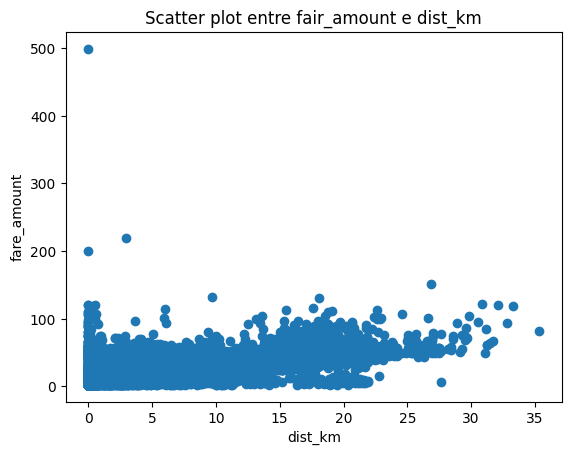

In [16]:
#Scatter plot entre fair_amount e dist_km
plt.scatter(df['dist_km'], df['fare_amount'])
plt.xlabel('dist_km')
plt.ylabel('fare_amount')
plt.title('Scatter plot entre fair_amount e dist_km')
plt.show()

In [17]:
#Remover corrida de custo 499 que tem distância baixa
df = df[df['fare_amount'] != 499]

Utilizando agora a coluna pickup_datetime vamos criar as seguintes variáveis categóricas:
###
hora - Em qual horário do dia a corrida foi realizada
###
dia_semana - Em qual dia da semana a corrida foi realizada (Sendo 0 segunda e 6 domingo)
###
mes - Em qual mês do ano a corrida foi realizada(De 1 a 12)
###
is_feriado - Se a corrida foi em um dia que é feriado nos EUA
###
hora_rush - Se a corrida foi realizado em horário de Rush


No final da função usamos a técnica one-hot encoding para transformar essas variáveis categóricas em variáveis numéricas binárias para que os modelos que vamos usar como Regressão Linear possam entender essas categorias.

In [18]:
import holidays

def criar_features_datetime(df, datetime_col='pickup_datetime'):
    """
    Adiciona várias features temporais para ML a partir de um datetime.

    Parâmetros:
        df: pandas.DataFrame
            Deve conter a coluna datetime_col
        datetime_col: str
            Nome da coluna datetime

    Retorno:
        DataFrame com novas colunas adicionadas.
    """

    # Garantir que é datetime
    df[datetime_col] = pd.to_datetime(df[datetime_col])

    # Hora do dia
    df['hora'] = df[datetime_col].dt.hour

    # Dia da semana (0=Segunda, 6=Domingo)
    df['dia_semana'] = df[datetime_col].dt.weekday

    # Mês do ano
    df['mes'] = df[datetime_col].dt.month

    # Feriados nos EUA
    us_holidays = holidays.US()
    df['is_feriado'] = df[datetime_col].dt.date.apply(lambda x: x in us_holidays).astype(int)

    # Rush hour: manhã (7-9) e tarde (17-19)
    df['hora_rush'] = df['hora'].apply(lambda x: 1 if 7 <= x <= 9 or 17 <= x <= 19 else 0)

    # Parte do dia
    def get_part_of_day(hour):
        if 6 <= hour < 12:
            return 'manha'
        elif 12 <= hour < 18:
            return 'tarde'
        elif 18 <= hour < 24:
            return 'noite'
        else:
            return 'madrugada'

    df['parte_dia'] = df['hora'].apply(get_part_of_day)


    #Criando um dataframe antes do One-Hot encoding para análise exploratória
    df_cat_cols = df
    # One-hot encoding das variáveis categóricas
    df = pd.get_dummies(df, columns=['hora', 'dia_semana', 'mes', 'parte_dia'], drop_first=True)

    return df, df_cat_cols


In [19]:
df, df_cat_cols = criar_features_datetime(df, datetime_col='pickup_datetime')
print(df.head())

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

            pickup_datetime  pickup_longitude  pickup_latitude  \
0 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count   dist_km  ...  mes_6  \
0         -73.999512         40.723217                1  1.683323  ...  False   
1         -73.994710         40.750325                1  2.457590  ...  Fa

1.3) Análise Exploratória de Dados

In [20]:
# Tipos de dados
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 191324 entries, 0 to 199999
Data columns (total 56 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Unnamed: 0         191324 non-null  int64              
 1   key                191324 non-null  object             
 2   fare_amount        191324 non-null  float64            
 3   pickup_datetime    191324 non-null  datetime64[ns, UTC]
 4   pickup_longitude   191324 non-null  float64            
 5   pickup_latitude    191324 non-null  float64            
 6   dropoff_longitude  191324 non-null  float64            
 7   dropoff_latitude   191324 non-null  float64            
 8   passenger_count    191324 non-null  int64              
 9   dist_km            191324 non-null  float64            
 10  dist_manhattan_km  191324 non-null  float64            
 11  is_feriado         191324 non-null  int64              
 12  hora_rush          191324 non-null 

1.3.1)Variáveis Contínuas

Vamos iniciar a nossa análise exploratória fazendo um histograma das nossas variáveis numéricas.

In [21]:
# Estatísticas de variáveis numéricas
num_cols = ['dist_km', 'dist_manhattan_km', 'fare_amount','passenger_count']
df[num_cols].describe()

,dist_km,dist_manhattan_km,fare_amount,passenger_count
count,191324.000000,191324.000000,191324.000000,191324.000000
mean,3.305580,4.252647,11.273349,1.589623
std,3.553129,4.694821,9.437117,1.153416
min,0.000000,0.000000,2.500000,0.000000
25%,1.256414,1.599591,6.000000,1.000000
50%,2.156650,2.762520,8.500000,1.000000
75%,3.901965,5.022242,12.500000,2.000000
max,35.341861,49.655657,220.000000,5.000000


Podemos notar que a distância Manhattan apresenta distância maiores para as corridas do que a distância Haversine, o que faz sentido já que a distância Harversine calcula em uma "linha reta" enquanto a Manhattan considera "linhas em grade". Isso fica ainda mais claro quando plotamos os histogramas dessas variáveis.

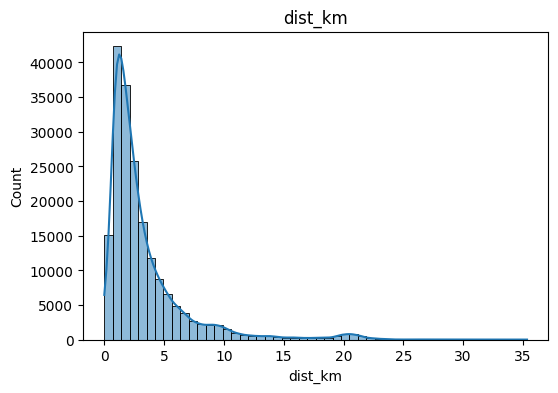

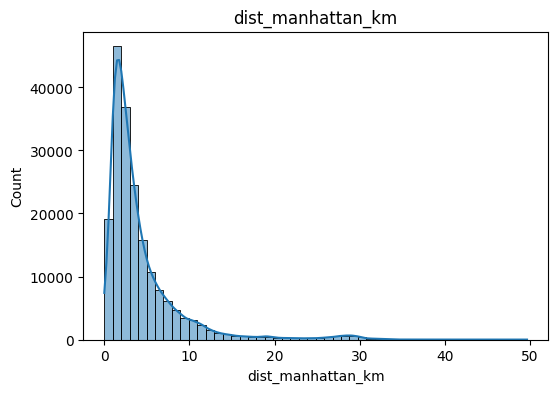

In [22]:
num_cols2 = ['dist_km', 'dist_manhattan_km']
for col in num_cols2:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(col)
    plt.show()


Agora fazemos o boxplot para as distâncias e para o valor das corridas, podemos ver que a maioria das corridas tem até 10km de distância, e que ate os maiores valores outliers são valores razoáveis para corridas em uma região metropolitana.
###
Em relação ao valor das corridas, já limpamos as que tinham valores negativos, e alguns valores outliers parecem ser exorbitantes, como o que removemos de $499 que tinha menos de 1km mas como não temos um contexto maior como o tempo que a corrida demorou, ou se ela foi feita a partir de uma região ou em algum evento específico, não da pra ter certeza que são valores errados, então não mexerei nesses dados.

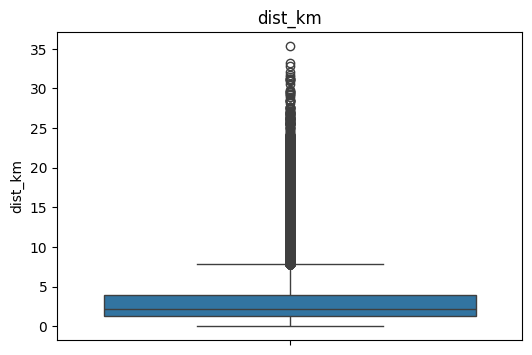

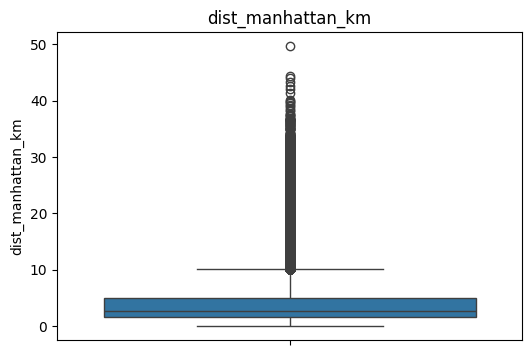

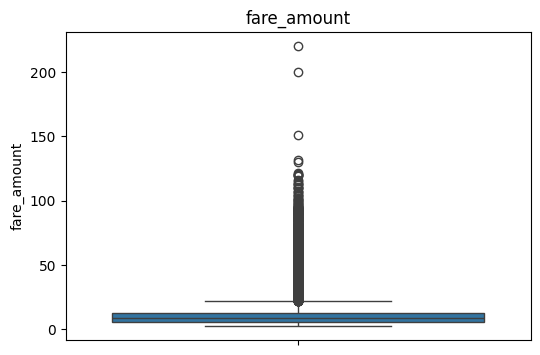

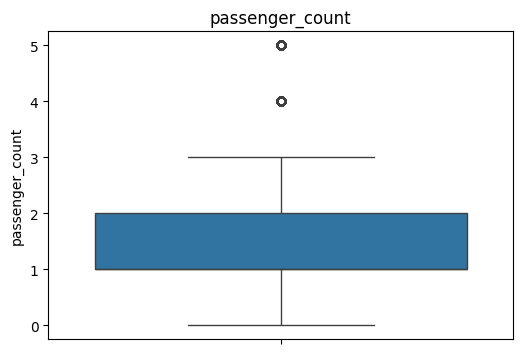

In [23]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.show()

Agora podemos ver que essas variáveis tem uma correlação bem alta com o valor das corridas, o que indica que a distância é um bom preditor, enquanto o número de passageiros não apresenta tanta correlação com o valor das corridas.

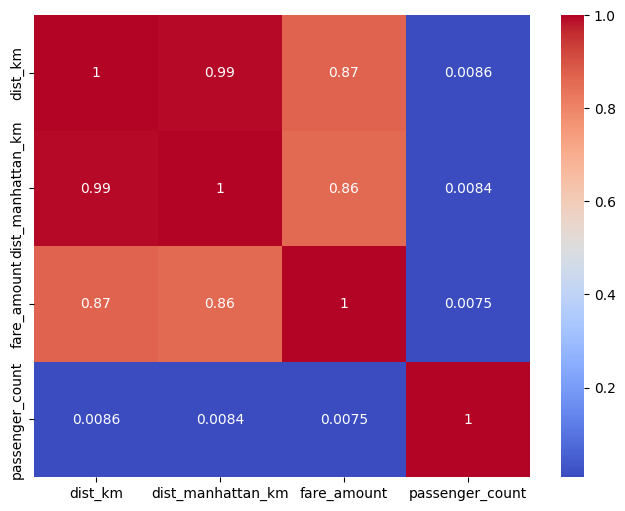

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.show()


1.3.2)Variáveis Categóricas

Vamos agora explorar nossas variáveis categóricas, podemos notar que a maioria das corridas acontecem na parte da noite, em relação aos dias da semana as corridas parecem bem distribuídas com um leve destaque para sexta e sábado que são os dias com mais corridas, o que faz sentido já que são dias que a maioria das pessoas costuma sair para lazer. Aproximadamente um terço das corridas acontecem no que definimos como horário de rush. Poucas corridas são feitas no feriado mas também temos poucos dias que são feriados.

Será calculado abaixo para melhor interpretação a média de corridas em dias normais x dias de feriado e corridas por hora de rush ou horário normal de trânsito.

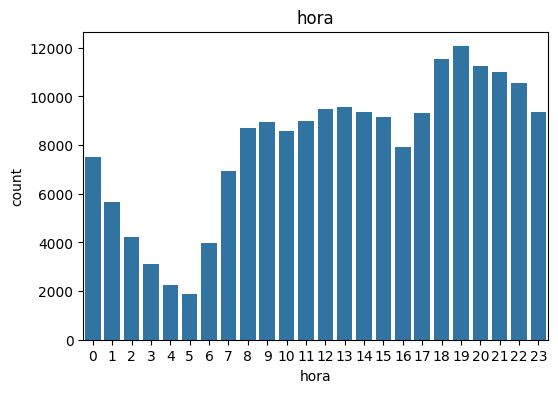

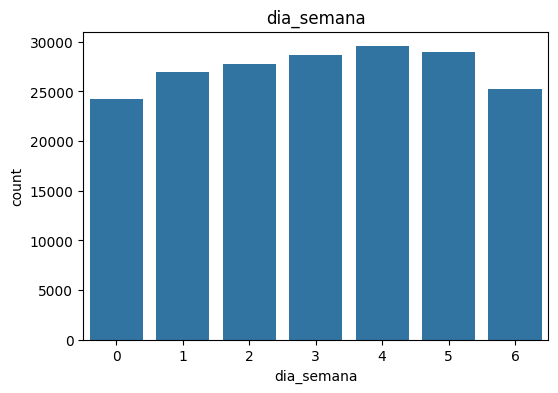

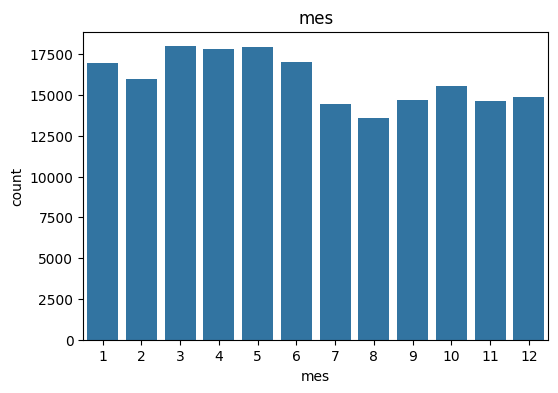

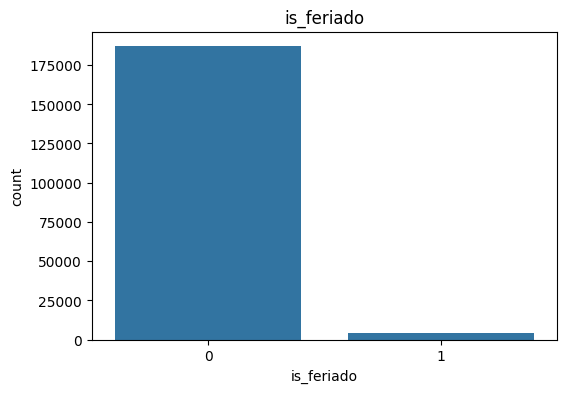

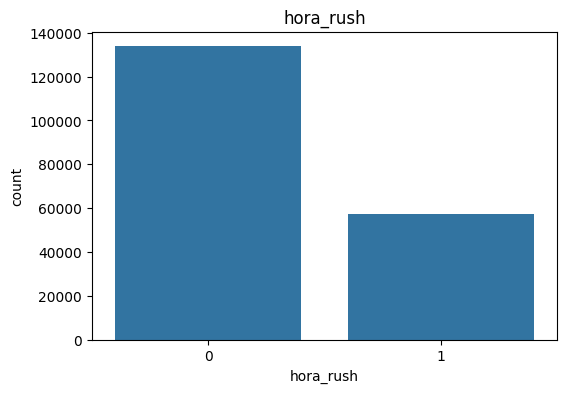

In [25]:
cat_cols = ['hora','dia_semana', 'mes', 'is_feriado','hora_rush',]
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df_cat_cols[col])
    plt.title(col)
    plt.show()

In [26]:
#Número médio de corridas em dias que são feriado e dias que não são feriado
df_cat_cols['date'] = df_cat_cols['pickup_datetime'].dt.date
total_days = df_cat_cols['date'].nunique()
holiday_days = df_cat_cols.groupby('is_feriado')['date'].nunique()
avg_rides_per_day_holiday = df_cat_cols.groupby('is_feriado').size().astype(float) / holiday_days

print("Média de corridas em dias que não são feriado (0) vs. dias que são feriado (1):")
display(avg_rides_per_day_holiday)

# Média de corridas em horário de rush
# Horário de rush foi definido de 7-9 e 16-19 (ou seja, 6 horas do dia)
rush_hour_hours = 6
non_rush_hour_hours = 18
avg_rides_per_hour_rush_hour = df_cat_cols.groupby('hora_rush').size()
avg_rides_per_hour_rush_hour[1] = avg_rides_per_hour_rush_hour[1].astype(float) / rush_hour_hours
avg_rides_per_hour_rush_hour[0] = avg_rides_per_hour_rush_hour[0].astype(float) / non_rush_hour_hours


print("Média de corridas em horas que não são de rush (0) vs horas de rush (1):")
display(avg_rides_per_hour_rush_hour)

Média de corridas em dias que não são feriado (0) vs. dias que são feriado (1):


,0
is_feriado,
0,81.266841
1,60.971831


Média de corridas em horas que não são de rush (0) vs horas de rush (1):


/tmp/ipython-input-94205426.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9581.833333333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  avg_rides_per_hour_rush_hour[1] = avg_rides_per_hour_rush_hour[1].astype(float) / rush_hour_hours


,0
hora_rush,
0,7435.166667
1,9581.833333


Podemos notar acima que temos em média menos corridas em dias que são feriados, talvez por as pessoas passarem mais tempo em casa e que conforme esperavamos temos em média mais corridas em horário de rush do que nas outras horas.

Agora vamos aprofundar um pouco mais na relação entre hora e dia da semana para analisarmos quais horários temos mais corridas em cada dia da semana.

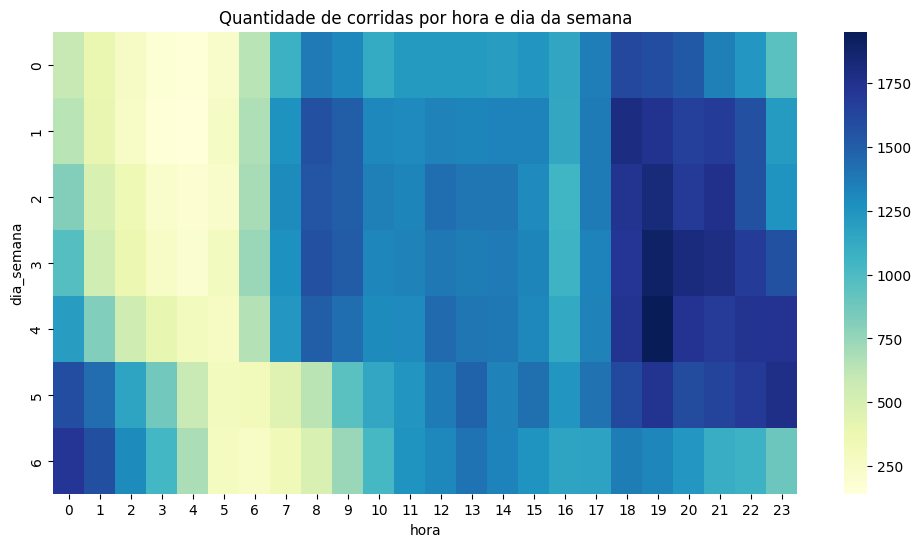

In [27]:
pivot = df_cat_cols.pivot_table(index='dia_semana', columns='hora', values='fare_amount', aggfunc='count')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title("Quantidade de corridas por hora e dia da semana")
plt.show()


Podemos notar que de modo geral temos a maior parte das corridas feitas no período da noite e que temos um aumento considerável do número de corridas em madrugadas no fim de semana.

In [28]:
for col in cat_cols:
    print(f"\nResumo por {col}:")
    print(df_cat_cols.groupby(col)['fare_amount'].describe())



Resumo por hora:
        count       mean        std  min  25%   50%    75%     max
hora                                                              
0      7508.0  11.513169   8.561286  2.5  6.1   8.9  13.70  100.30
1      5647.0  11.515780   8.471517  2.5  6.1   8.9  14.00  110.00
2      4236.0  11.238978   8.244911  2.5  6.1   8.9  13.50  120.08
3      3120.0  11.568554   8.467882  2.5  6.1   9.0  14.10   95.00
4      2264.0  13.734108  11.254715  2.5  6.5  10.0  17.00   89.50
5      1883.0  15.980127  15.523028  2.5  6.0   9.3  19.85  131.93
6      3972.0  11.937085  11.686444  2.5  5.5   7.7  12.50  106.50
7      6931.0  11.057136   9.878590  2.5  5.7   8.0  12.00   86.00
8      8683.0  10.745868   8.852227  2.5  5.7   8.1  12.10  119.00
9      8933.0  10.889631   8.805255  2.5  6.0   8.5  12.10  110.00
10     8564.0  10.954754   9.123792  2.5  6.0   8.1  12.10  110.00
11     8994.0  11.170404   9.461396  2.5  6.0   8.1  12.10  105.29
12     9486.0  11.120069   9.375899  2.5  6.

Por fim olhando algumas estatísticas descritivas desses variáveis podemos notar que o que pelo menos eu considerava como intuitivo não se traduz nos dados, como corridas em horário de rush tem em média valor menor do que em horários normais, ou que em dias como sexta e sábado que tem mais corridas o preço seria mais alto, talvez apesar da demanda ser maior exista uma oferta também maior de motoristas trabalhando nesses períodos o que acaba se traduzindo no que vemos nos dados e também seria interessante analisar o tempo que essas corridas levam mas não temos essa informação no dataset.

O que podemos notar com maior destaque são que os horários de fim de madrugada são os que tem maior valor em média, o que se é esperado já que existe uma menor oferta de motoristas nesses horários.

Parte 2) Treinamento e validação dos modelos de regressão.

Optei por deixar a dist_km ao invés da dist_manhattan_km para utilização como variável preditora, cheguei a testar separadamente mas tiveram resultados quase idênticos.

2.1) Definição de variáveis e separação dos conjuntos de treino e teste

In [29]:
#Definição da variáveis preditoras e variável resposta
#Optei por escolher a dist_km ao invés de dist_manhattan_km, resultados são parecidos com as duas distâncias
x = df.drop(columns = ['fare_amount','dist_manhattan_km','Unnamed: 0','key','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'])
y = df['fare_amount']


#Separação dos conjuntos de treino e teste
X_tr, X_te, y_tr, y_te = train_test_split(x,y, test_size=0.2, random_state=42, shuffle=True)

In [30]:
print(X_tr.shape) #Temos 47 variáveis preditoras
print(X_te.shape)
print(y_tr.shape)
print(y_te.shape)

(153059, 47)
(38265, 47)
(153059,)
(38265,)


2.2) Métodos Paramétricos

2.2.1) Regressão Linear

In [31]:
LinReg = LinearRegression()
LinReg.fit(X_tr, y_tr)

LinearRegression()

No gráfico abaixo podemos ver que uma das variáveis aparenta ser a mais importante, e de fato conforme esperávamos pode ser visto na tabela que essa variável é a da distância.

Alguns outros pontos interessantes que podemos ver, é que corridas a tarde tendem a ser mais caras e alguns horários do dia como por exemplo as horas 6 e 7 tendem a ser mais baratas, provavelmente porque tem uma oferta maior de motoristas disponíveis. Corridas em feriado também são mais baratos o que pode parecer contraintuitivo mas faz sentido se pensarmos que as pessoas acabam ficando em casa ao invés de sair pra trabalhar.

<StemContainer object of 3 artists>

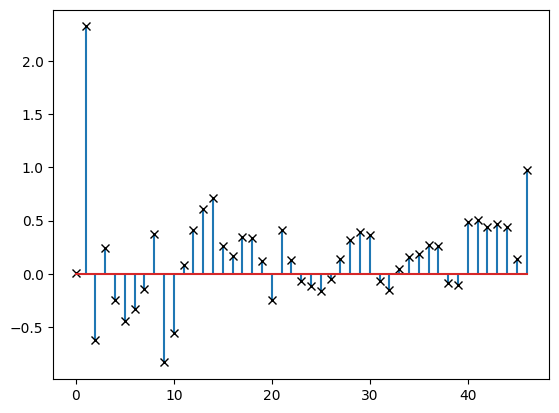

In [32]:
plt.stem(LinReg.coef_, markerfmt = 'kx', label = 'LinReg')

In [33]:
#Criar DataFrame com variáveis e coeficientes
coef_df = pd.DataFrame({
    "Variável": x.columns,
    "Coeficiente": LinReg.coef_
})

#Ordenar pelo valor absoluto dos coeficientes
coef_df["Coeficiente_abs"] = np.abs(coef_df["Coeficiente"])
top10 = coef_df.sort_values(by="Coeficiente_abs", ascending=False).head(10)

print(top10[["Variável", "Coeficiente"]])


           Variável  Coeficiente
1           dist_km     2.324116
46  parte_dia_tarde     0.978709
9            hora_6    -0.832602
14          hora_11     0.714434
2        is_feriado    -0.617027
13          hora_10     0.606683
10           hora_7    -0.553484
41           mes_10     0.508550
40            mes_9     0.486071
43           mes_12     0.468782


In [34]:
y_te_pred_LinReg = LinReg.predict(X_te)

In [35]:
print(f'sqrt(MSE) LinReg: {np.sqrt(MSE(y_te_pred_LinReg, y_te))}')

sqrt(MSE) LinReg: 4.417650360733591


2.2.2) Lasso com validação cruzada

In [36]:
grid_alpha = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}

LasCV = GridSearchCV(estimator = Lasso(),
                     param_grid = grid_alpha,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     verbose = 4,
                     refit = True
                     )

In [37]:
LasCV.fit(X_tr, y_tr)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .....................alpha=0.001;, score=-23.881 total time=   1.9s
[CV 2/5] END .....................alpha=0.001;, score=-20.154 total time=   1.9s
[CV 3/5] END .....................alpha=0.001;, score=-22.808 total time=   1.7s
[CV 4/5] END .....................alpha=0.001;, score=-20.795 total time=   1.7s
[CV 5/5] END .....................alpha=0.001;, score=-20.272 total time=   3.7s
[CV 1/5] END ......................alpha=0.01;, score=-23.939 total time=   1.3s
[CV 2/5] END ......................alpha=0.01;, score=-20.191 total time=   0.8s
[CV 3/5] END ......................alpha=0.01;, score=-22.862 total time=   0.8s
[CV 4/5] END ......................alpha=0.01;, score=-20.860 total time=   0.8s
[CV 5/5] END ......................alpha=0.01;, score=-20.321 total time=   0.8s
[CV 1/5] END .......................alpha=0.1;, score=-24.217 total time=   0.3s
[CV 2/5] END .......................alpha=0.1;, s

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]},
             scoring='neg_mean_squared_error', verbose=4)

In [38]:
y_te_pred_LasCV = LasCV.predict(X_te)

In [39]:
print(f'sqrt(MSE) Lasso: {np.sqrt(MSE(y_te_pred_LasCV, y_te))}')

sqrt(MSE) Lasso: 4.417672389661775


2.2.3) Ridge com validação cruzada

In [40]:
RidgeCV = GridSearchCV(estimator = Ridge(),
                     param_grid = grid_alpha,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     verbose = 4,
                     refit = True
                     )

In [41]:
RidgeCV.fit(X_tr, y_tr)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .....................alpha=0.001;, score=-23.879 total time=   0.1s
[CV 2/5] END .....................alpha=0.001;, score=-20.154 total time=   0.1s
[CV 3/5] END .....................alpha=0.001;, score=-22.807 total time=   0.1s
[CV 4/5] END .....................alpha=0.001;, score=-20.792 total time=   0.1s
[CV 5/5] END .....................alpha=0.001;, score=-20.272 total time=   0.1s
[CV 1/5] END ......................alpha=0.01;, score=-23.879 total time=   0.1s
[CV 2/5] END ......................alpha=0.01;, score=-20.154 total time=   0.1s
[CV 3/5] END ......................alpha=0.01;, score=-22.807 total time=   0.1s
[CV 4/5] END ......................alpha=0.01;, score=-20.792 total time=   0.1s
[CV 5/5] END ......................alpha=0.01;, score=-20.272 total time=   0.1s
[CV 1/5] END .......................alpha=0.1;, score=-23.879 total time=   0.1s
[CV 2/5] END .......................alpha=0.1;, s

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]},
             scoring='neg_mean_squared_error', verbose=4)

In [42]:
y_te_pred_RidgeCV = RidgeCV.predict(X_te)

In [43]:
print(f'sqrt(MSE) Ridge: {np.sqrt(MSE(y_te_pred_RidgeCV, y_te))}')

sqrt(MSE) Ridge: 4.417671100371797


2.2.4) Elastic Net com validação cruzada

In [44]:
l1_ratios = np.linspace(0.1, 0.9, 5, endpoint= True) # Grade de busca para o l1_ratio
grid_ElaNet = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
                'l1_ratio': l1_ratios}

ElaNetCV = GridSearchCV(estimator = ElasticNet(),
                     param_grid = grid_ElaNet,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     verbose = 1,
                     refit = True)

In [45]:
ElaNetCV.fit(X_tr, y_tr)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
                         'l1_ratio': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring='neg_mean_squared_error', verbose=1)

In [46]:
y_te_pred_ElaNetCV = ElaNetCV.predict(X_te)

In [47]:
print(f'sqrt(MSE) ElasticNet: {np.sqrt(MSE(y_te_pred_ElaNetCV, y_te))}')

sqrt(MSE) ElasticNet: 4.417685132800485


Podemos ver que não alteração significativa nos coeficientes com os modelos com penalização(o que pode ser visto pelos valores de alpha selecionados através da validação cruzada), o resultado é muito parecido com a da Regressão por Mínimos Quadrados, o que faz sentido já que a maioria das nossas variáveis são binárias por conta do one-hot encoding e com isso temos pouca colinearidade entre as variáveis preditoras.

Portanto entre os métodos paramétricos, eu escolheria o de Regressão Linear por ser mais simples que os outros e apresentar resultado igual.


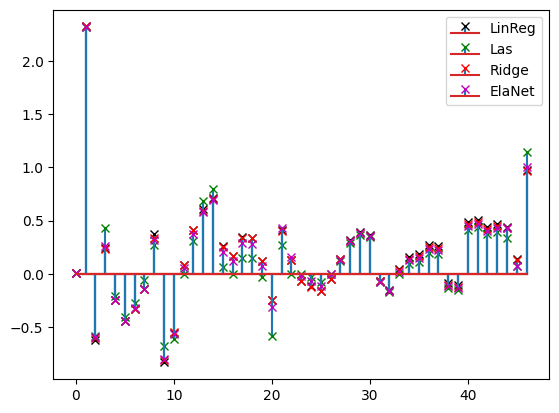

In [48]:
plt.stem(LinReg.coef_, markerfmt = 'kx', label = 'LinReg') # Plota a estimativa para beta, com a "cabeça" sendo cruzes pretas
plt.stem(LasCV.best_estimator_.coef_, markerfmt = 'gx', label = 'Las') # Plota a estimativa para beta, através do lasso, com a "cabeça" sendo cruzes verdes
plt.stem(RidgeCV.best_estimator_.coef_, markerfmt = 'rx', label = 'Ridge') # Plota a estimativa para beta, com a "cabeça" sendo cruzes vermelhas
plt.stem(ElaNetCV.best_estimator_.coef_, markerfmt = 'mx', label = 'ElaNet') # Plota a estimativa para beta, com a "cabeça" sendo cruzes magentas

plt.legend()
plt.show()

2.3) Métodos não-paramétricos

2.3.1) KNN com validação cruzada

Tive que adaptar a escolha de parâmetros para validação cruzada do KNN, na primeira vez que rodei o código, foi o método que mais demorou levando mais de uma hora, com os parâmetros comentados e com o número de vizinho igual a 10 que era o limite do intervalo.

In [49]:
param_grid_KNN = {'n_neighbors': [1, 5, 10,20,30]}#'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                  #'weights': ['uniform', 'distance'],
                  #'p': [1, 2]}


KNNCV = GridSearchCV(estimator = KNeighborsRegressor(),
                     param_grid = param_grid_KNN,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     verbose = 4,
                     n_jobs = -1,
                     refit = True)

O KNN aparentemente está sempre escolhendo o maior valor de vizinhos próximos o que pode ser porque a maioria das nossas variáveis são binárias(0 ou 1) por conta do one-hot encoding e por isso a distância acaba perdendo um pouco de interpretação, apesar disso apresentou o melhor resultado entre os modelos até agora.

Como a validação cruzada já está escolhendo um valor alto de vizinhos não vi necessidade de utilizar o bagging porque o modelo já está bem estável, o mesmo serve para os modelos de regressão que são estáveis(baixa variância) por natureza.

In [50]:
KNNCV.fit(X_tr, y_tr)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 30]},
             scoring='neg_mean_squared_error', verbose=4)

In [51]:
y_te_pred_KNNCV = KNNCV.predict(X_te)

In [52]:
print(f'sqrt(MSE) KNN: {np.sqrt(MSE(y_te_pred_KNNCV, y_te))}')

sqrt(MSE) KNN: 4.344995258208657


2.3.2.1) Árvore de Regressão com validação cruzada

In [53]:
param_grid_DTR = {'ccp_alpha': [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9]}

DTRCV = GridSearchCV(estimator = DecisionTreeRegressor(max_depth = None, min_samples_leaf= 5),
                     param_grid = param_grid_DTR,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = -1)

In [54]:
DTRCV.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(min_samples_leaf=5),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9]},
             scoring='neg_mean_squared_error')

In [55]:
y_te_pred_DTRCV = DTRCV.predict(X_te)

In [56]:
print(f'sqrt(MSE) DecisionTree: {np.sqrt(MSE(y_te_pred_DTRCV, y_te))}')

sqrt(MSE) DecisionTree: 4.383506302302375


2.3.2.2) Árvore de Regressão com Bagging

In [57]:
DTRBag = BaggingRegressor(estimator = DecisionTreeRegressor(max_depth = None, min_samples_leaf= 5),
                          n_estimators = 200,
                          n_jobs = -1)

In [58]:
DTRBag.fit(X_tr, y_tr)

BaggingRegressor(estimator=DecisionTreeRegressor(min_samples_leaf=5),
                 n_estimators=200, n_jobs=-1)

In [59]:
y_te_pred_DTRBag = DTRBag.predict(X_te)

In [60]:
print(f'sqrt(MSE) DecisionTreeBag: {np.sqrt(MSE(y_te_pred_DTRBag, y_te))}')

sqrt(MSE) DecisionTreeBag: 4.278425511583279


Podemos ver que a árvore de regressão através apenas da validação cruzada deu resultado um pouco pior ao KNN enquanto com Bagging de forma simples já trouxe um resultado melhor, pode parecer pouca diferença mas se estamos falando de alguns centavos por corrida para uma empresa que faz uma quantidade muito grande de corridas por dia essa diferença é considerável para o resultado da empresa.

O Bagging ter melhorado o resultado também indica que as florestas aleatórias podem ter um resultado ainda melhor.

2.3.3) Florestas Aleatórias

In [61]:
RF = RandomForestRegressor(n_estimators = 200,
                           max_depth = None,
                           min_samples_leaf=5,
                           max_features= 0.3,
                           bootstrap = True,
                           n_jobs = -1)


In [62]:
RF.fit(X_tr, y_tr)

RandomForestRegressor(max_features=0.3, min_samples_leaf=5, n_estimators=200,
                      n_jobs=-1)

In [63]:
print(f'sqrt(MSE) RandomForest: {np.sqrt(MSE(RF.predict(X_te), y_te))}')

sqrt(MSE) RandomForest: 4.255509211238157


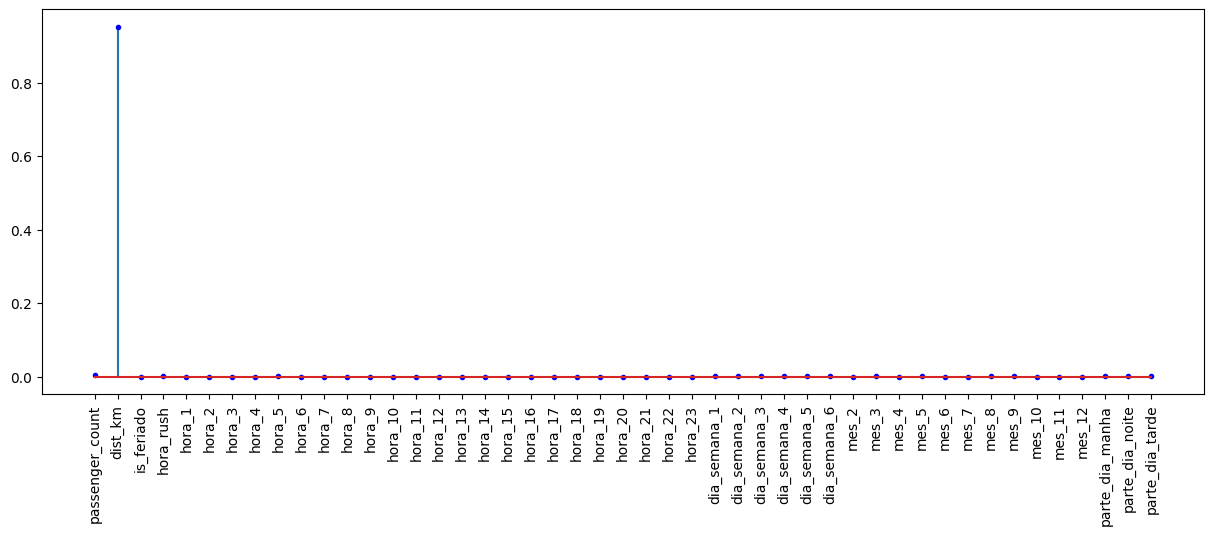

In [64]:
RF.feature_importances_

plt.figure(figsize = (15, 5))
plt.stem(RF.feature_importances_, markerfmt = '.b')
plt.xticks(range(len(list(X_tr.columns))), list(X_tr.columns), rotation = 'vertical')

plt.show()

Como esperávamos a floresta aleatória obteve o melhor resultado, podemos ver acima que de longe a distância é o preditor mais importante para o valor da corrida enquanto os outros preditores tem pouca relevância.

3)Conclusão

Podemos concluir, primeiramente, que o principal preditor para os preços de corrida é a distância, seria interessante como uma futura melhoria se pudessemos utilizar a rota real das corridas para calcular a distância com mais precisão, o que certamente deixaria nosso modelo mais acurado. Além disso, se tivessemos o horário final da corrida, isso nos permitiria calcular a duração total, que de forma intuitiva parece ser um bom preditor. Isso também ajudaria a identificar se algumas corridas do nosso conjunto de dados são atípicas ou se tem inconsistência nos dados e precisariam ser limpados, outras informações como o histórico de engarrafamentos e/ou variáveis meteorológicas seriam interessantes preditores.

Em relação a performance dos modelos podemos interpretar de duas formas, se estamos pensando como a Uber uma empresa gigante que não tem problemas com o custo computacional certamente o modelo que apresentou melhor resultado foram as Florestas Aleatórias e poderíamos aprofundar ainda mais na otimização da performance desse modelo ou de outros como o KNN que pareceu ter um alto custo computacional com os parâmetros escolhidos inicialmente. Por outro lado, se o nosso objetivo for praticidade e um bom custo benefício operacional,talvez se estivermos enxergando como um motorista querendo prever seus ganhos ou um pesquisador que quer entender os fatores que influenciam preço ou até mesmo o desenvolvimento de um aplicativo de celular que precisa fazer previsões em tempo real, a Regressão Linear já aparenta ser uma solução satisfatória com boa performance e baixo custo computacional.